# SPECnet v1.0
(Choose "Run All" from the "Cell" menu, above, to run the simulation. Then scroll to the bottom of the page.)

## Input parameters

In [6]:
using sim

## Input parameters
params = Dict{Symbol,Any}(
    :N => 30,                        # number of agents
    :num_iter => 100,                # number of iterations the simulation runs
    :openness => 0,                  # 0 <=> openness <=> 1   (0: always choose from neighbor, 1: always choose from entire city)
    :max_starting_wealth => 100,     # each agent starts with wealth U~(0,max_starting_wealth)
    :salary_range => 10,             # each iteration, each agent receives/loses U~(-salary_range, salary_range) wealth
    :proto_threshold => 50,          # each agent in an encounter must have wealth about proto_threshold to form a proto
    :make_anim => true,              # do, or do not, (re-)create an animation of results
    :animation_delay => 20,          # milliseconds between animation frames
    :random_seed => 1234,            # random number generator starting seed
)
display(params)

Dict{Symbol,Any} with 9 entries:
  :salary_range        => 10
  :random_seed         => 1234
  :N                   => 30
  :num_iter            => 100
  :max_starting_wealth => 100
  :proto_threshold     => 50
  :animation_delay     => 20
  :openness            => 0
  :make_anim           => true

## Simulation

SPECnet simulation parameters:
   salary_range = 10
   random_seed = 1234
   N = 30
   num_iter = 100
   max_starting_wealth = 100
   proto_threshold = 50
   animation_delay = 20
   openness = 0
   make_anim = true
Running SPECnet...
Iterations:
.........10
.........20
.........30
.........40
.........50
.........60
.........70
.........80
.........90
.........100
Building animation...


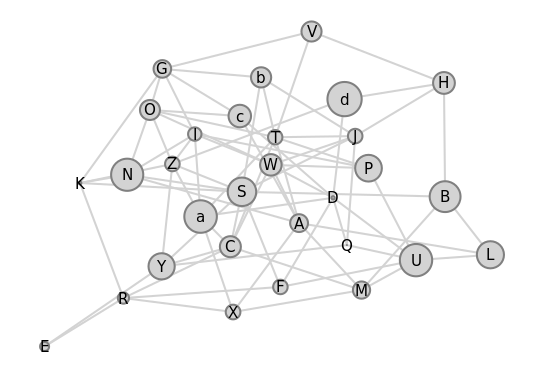

...end SPECnet.


In [7]:
specnet(params)
                                    
display("image/gif", read("$(tempdir())/output.gif"))